# Fast AI Model Prediction Done Over Sudo Labelled + Labelled Data

## Importing and intalling Libraries Required

In [1]:
import pandas as pd #For Reading csv file
!pip install fastai
from fastai.text import *

### Reading Labelled data into Pandas DataFrame

In [2]:
labelledData = pd.read_csv('labeled_data.csv')
labelledData.head()

,text,label
0,The new rule is - \r\nif you are waiting for a...,4
1,"Flirted with giving this two stars, but that's...",3
2,I was staying at planet Hollywood across the s...,5
3,Food is good but prices are super expensive. ...,2
4,Worse company to deal with they do horrible wo...,1


### Reading Pseudo Labelled Data (just 50000 Rows of Total Unlabelled data) into Pandas DataFrame

In [3]:
unlabelled50 = pd.read_csv('pseudo_labelled_50k.csv')
#Removing Unwanted Columns From the Data
unlabelled50.drop("Unnamed: 0",axis=1,inplace=True)

### Combining Pseudo Labelled Data + Labelled Data into a single DataFrame

In [5]:
labelled_data = pd.concat([labelledData, unlabelled50], ignore_index=True)
labelled_data.shape

(100000, 2)

### Splitting the dataset into training and test dataset (75:25)

In [6]:
train = labelled_data.sample(frac=0.75, random_state=0)
test = labelled_data.drop(train.index)

### Load and analyse data for fast ai
 Fast ai expects the data as a data bunch so that it can use this for generating models. Here we will first create a data bunch with our train data set.

In [7]:
data = (TextList.from_df(train, cols='text')
                .split_by_rand_pct(0.2)
                .label_for_lm()  
                .databunch(bs=48))
data.show_batch()

idx,text
0,"a spa / big tub in the common area which had wall paper peeling off the wall and under that was mold . xxmaj there were mild stains on the ceiling too , as if it was painted over . xxmaj that 's just unhealthy . xxmaj we also requested extra towels one day and maid service did n't even knock - they just walked right in . xxmaj petty"
1,"great ! xxmaj perfect texture ! i ve even tried their vegan ice creams for milkshakes and they taste great ! i have loved everything i have tried . \r \n xxmaj now for the bad stuff . xxmaj in summary , if there were another shop near my home selling boba , i would nt go to this shop anymore . xxmaj when i come in , i"
2,"gone to somewhere and backed up already ! "" \r \n \r \n xxmaj robert response to that was "" oh , that 's not xxmaj roys ' job , his job is to make the appointment ! xxmaj and ma'am , you have a great day ! "" \r \n \r \n xxmaj really ? xxmaj his job is to make an appointment xxup only ? xxmaj"
3,", bench seats , it was nt impressive at a glance . xxbos xxmaj do not use this company ! \r \n xxmaj we moved from xxmaj california to xxmaj arizona . a lot of our things were broken . xxmaj almost everything was covered in a black dust . xxmaj we filled out a lengthy claim and was not reimbursed anything close to the amount of damage they"
4,"is too smoothie like consistency . i like 'em chunky . \r \n \r \n xxmaj as for service , it 's just like any other restaurant that have xxunk to it . xxmaj you sit down , they 'll bring out water . xxmaj then they 'll ask you if you want anything other than water to drink . xxmaj after the drink , they take your food"


### Fit the deep learning model with domain specific data
First we will fit our model with train data without target values so that our model knows better about our data.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,time
0,4.020051,3.914527,0.277494,05:45
1,4.031332,3.911330,0.277409,05:48
2,3.943885,3.852639,0.282906,05:47
3,3.818020,3.792716,0.288776,05:45
4,3.725049,3.777608,0.290486,05:47


epoch,train_loss,valid_loss,accuracy,time
0,3.553485,3.622592,0.307916,06:46
1,3.505320,3.541296,0.319163,06:49
2,3.404741,3.487961,0.326596,06:46
3,3.231501,3.465258,0.330456,06:45
4,3.130376,3.472252,0.330656,06:46


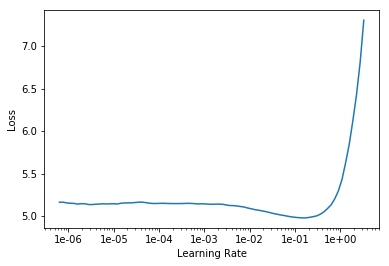

In [8]:
learn = language_model_learner(data,AWD_LSTM, drop_mult=0.3)

# select the appropriate learning rate
learn.lr_find()

# we typically find the point where the slope is steepest
learn.recorder.plot()

# Fit the model based on selected learning rate
learn.fit_one_cycle(5, 1e-2, moms=(0.8,0.7))

# Tune a little more
learn.unfreeze()
learn.fit_one_cycle(5, 1e-3, moms=(0.8,0.7))

# Save the encoder for use in classification
learn.save_encoder('fine_tuned_enc')

### Re-fit model with classification label
Here we will re-fit our model with our target values and tuned our model for better accuracy result.

In [9]:
test_datalist = TextList.from_df(test, cols='text', vocab=data.vocab)

data_clas = (TextList.from_df(train, cols='text', vocab=data.vocab)
             .split_by_rand_pct(0.2)
             .label_from_df(cols= 'label')
             .add_test(test_datalist)
             .databunch(bs=32))

data_clas.show_batch()

text,target
"xxbos i am not a xxunk reviewer , in fact , i rarely do so . xxmaj however , the xxup second of two bad experiences really motivated me to do so due to the sheer arrogance of nonetheless - the owner ! xxmaj yes - the owner ! ! \r \n \r \n xxmaj first xxmaj negative xxmaj experience : xxmaj went on a xxmaj sunday with my",1
"xxbos i 'm on the fence about this xxrep 4 . the wrong side , that is . \r \n \r \n i have seen the reviews and i have driven past this store at least ten times . \r \n \r \n xxmaj today , a girlfriend and i wanted to stop in . \r \n \r \n xxmaj we checked out the store 's xxmaj",1
"xxbos xxmaj my summer fishing buddy back on xxmaj cape xxmaj cod in 1976 was named xxmaj tom . xxmaj this was the summer after xxmaj jaws took the world by storm , so the vibe on the xxmaj cape at that time was surreal . i 'd liken it to xxmaj san xxmaj francisco just 7 years prior but i was n't there at the time ( xxmaj vietnam",3
"xxbos xxmaj well ... despite all the xxunk i had in the past , xxmaj in xxmaj september , i decided to renew my lease for 12 months . xxmaj living here is just ok as long as you do n't have any issues . i still do n't recommend any apartments managed by xxup amc , however . xxmaj they would n't work with me on the rent even",3
"xxbos xxmaj update : i very much dislike the idea of having to leave any stars at all . xxmaj just to be clear , if i could give xxmaj executive xxmaj moving and xxmaj storage 5 xxup negative stars i would xxup gladly do so . xxmaj the woman who contracted my move , which was with xxmaj revolution xxmaj moving xxmaj systems went by the name of xxmaj",1


Now let’s predict the target values and compare with original target values.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,time
0,0.982946,0.870274,0.615467,02:20
1,0.969066,0.825968,0.646533,02:19
2,0.956038,0.835212,0.642267,02:19
3,0.899756,0.789912,0.661733,02:21
4,0.903724,0.793713,0.664200,02:22


epoch,train_loss,valid_loss,accuracy,time
0,0.865223,0.923702,0.689533,02:46
1,0.782517,0.735513,0.704133,02:46
2,0.746461,0.680586,0.719067,02:46
3,0.658201,0.714906,0.732000,02:46
4,0.637628,0.744451,0.733467,02:46


epoch,train_loss,valid_loss,accuracy,time
0,0.630145,0.688929,0.729467,04:09
1,0.654547,0.675928,0.732200,04:11
2,0.571280,0.665220,0.738000,04:12
3,0.446153,0.740242,0.738267,04:10
4,0.391682,0.727097,0.739267,04:09


text,target,prediction
"xxbos i believe this hospital and xxup er has been instructed to treat as little as possible , and to make it xxup so difficult to be seen that you give up and go home . xxmaj while you wait - in the xxup er , you hear the staff complain . xxmaj about hours . xxmaj about patients . xxmaj about how tired they are . xxmaj the doctors",1,1
"xxbos xxmaj stayed here as a guest from a xxmaj wyndham timeshare owner . xxmaj only reason we stayed here was all the xxmaj wyndham 's were booked for spring break week . xxmaj we use a two room ( a , b ) suite for a little over a week . xxmaj still here actually . \r \n \r \n xxmaj check in went fine however they did",2,2
xxbos xxmaj hey there ! xxmaj from the looks of things you 're in the mood for some cooked animal . i know how you feel . xxmaj it was n't all that long ago when the same feeling came over me . xxmaj my primitive brain and its desire to xxunk on some protein that once had eyes was calling . i needed to stuff my xxunk with as,4,4
"xxbos xxmaj as a local staying in a hotel , i 've got a very different view - but i have to say i enjoyed the stay here , and do n't have much to complain about . \r \n \r \n xxmaj the staff were friendly , and rooms were clean . xxmaj the food was meh , but as expected from a hotel . \r \n \r",3,3
"xxbos i was n't expecting much when i flew xxmaj allegiant xxmaj air , but they failed to live up to even those low expectations . xxmaj considering the dirt - cheap airfare , i was n't exactly expecting a first class experience . i did , however , expect a less than miserable experience . xxmaj with little exception , xxmaj allegiant was miserable from beginning to end .",1,1


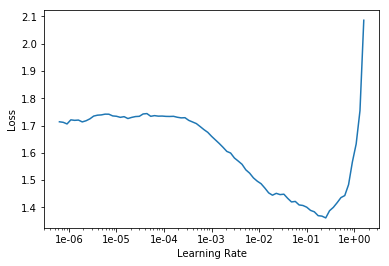

In [10]:
learn_classifier = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)

# load the encoder saved  
learn_classifier.load_encoder('fine_tuned_enc')

learn_classifier.freeze()

# select the appropriate learning rate
learn_classifier.lr_find()

# we typically find the point where the slope is steepest
learn_classifier.recorder.plot()

# Fit the model based on selected learning rate
learn_classifier.fit_one_cycle(5, 2e-2, moms=(0.8,0.7))

# Tune a little more
learn_classifier.freeze_to(-2)
learn_classifier.fit_one_cycle(5, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

# Tune a little more
learn_classifier.freeze_to(-3)
learn_classifier.fit_one_cycle(5, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

learn_classifier.show_results()

Here we can see that in the final round it is showing accuracy around 73.9%

### Loading Test Data

In [ ]:
test_data = pd.read_csv('test_data.csv')
test_data.head()

Filtering Predicted values into an array

In [ ]:
#Predicting the values for each text and appending the result into an Array
pred = []
for value in test_data['text']:
  y = learn_classifier.predict(value)
  pred.append(y)
#extracting just the predicted values from teh resultset tupple
temp = []
for each in pred:
  temp.append(each[0])

Appending that array into test data and removing unwanted columns

In [ ]:
test_data.drop('text', axis=1, inplace=True)
test_data['label']=temp
test_data.set_index("test_id",inplace = True)

Writing the final result into a csv file 

In [ ]:
test_data.to_csv("predict_label.csv")